In [46]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
!pip install pycocotools
!pip install timm

In [48]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-s3zicv0_
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-s3zicv0_
ERROR: Operation cancelled by user


In [49]:
#!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

Cloning into 'apex'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
^C


In [52]:
import sys
sys.path.insert(0, '/content/drive/My Drive/GWD/timm_efficientdet_pytorch')
sys.path.insert(0, '/content/drive/My Drive/GWD/omegaconf')

import pandas as pd
import numpy as np
import random
import os
import re
import cv2
from glob import glob
import time
from datetime import datetime
from apex import amp

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import warnings 
warnings.filterwarnings('ignore')

In [53]:
DIR_PATH = '/content/drive/My Drive/GWD/global-wheat-detection'

In [54]:
train = pd.read_csv(f'{DIR_PATH}/train.csv')
test_pseudo = pd.read_csv('/content/drive/My Drive/GWD/test_pseudo.csv')
train

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


In [55]:
train['x'] = 0; train['y'] = 0; train['w'] = 0; train['h'] = 0

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train[['x', 'y', 'w', 'h']] = np.stack(train['bbox'].apply(lambda x: expand_bbox(x)))
train.drop(['bbox'], inplace=True, axis=1)

train = pd.concat([train, test_pseudo])

train['x'] = train['x'].astype(np.float)
train['y'] = train['y'].astype(np.float)
train['w'] = train['w'].astype(np.float)
train['h'] = train['h'].astype(np.float)

In [56]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = train[['image_id']].copy()

df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = train[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

# splitting based on number of bboxes and source
for fold, (train_idx, valid_idx) in enumerate(skf.split(X=df_folds.index, y=df_folds['group'])):
    df_folds.loc[df_folds.iloc[valid_idx].index, 'fold'] = fold

df_folds

,bbox_count,source,group,fold
image_id,,,,
00333207f,55,arvalis_1,arvalis_1_3,1
005b0d8bb,20,usask_1,usask_1_1,3
006a994f7,25,inrae_1,inrae_1_1,1
00764ad5d,41,inrae_1,inrae_1_2,0
00b5fefed,25,arvalis_3,arvalis_3_1,3
...,...,...,...,...
ffb445410,57,rres_1,rres_1_3,1
ffbf75e5b,52,arvalis_1,arvalis_1_3,1
ffbfe7cc0,34,arvalis_1,arvalis_1_2,3


In [57]:
def get_train_transforms():
     return A.Compose([
        A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.75),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75)
        ], p=0.7),
        #A.GaussNoise(var_limit=(0.2, 1.0), p=0.3),
        #A.ToGray(p=0.01),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Resize(height=512, width=512, p=1.0),
        A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
        ToTensorV2(p=1.0)
    ], p=1.0,
        bbox_params = A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels'])
    )
    
def get_valid_transforms():
    return A.Compose([
        A.Resize(height=512, width=512, p=1.0),
        ToTensorV2(p=1.0)
    ], p=1.0,
        bbox_params = A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels'])
    )

In [58]:
class WheatDataset(Dataset):
    def __init__(self, data, image_ids, transforms=None, test=None):
        super().__init__()
        
        self.data = data
        self.image_ids = image_ids
        self.transforms = transforms
        self.test = test
        
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)
            
        labels = torch.ones((boxes.shape[0], ), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:, [0, 1, 2, 3]] = target['boxes'][:, [1, 0, 3, 2]]
                    target['labels'] = torch.stack(sample['labels'])
                    
                    break
                    
        return image, target, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]
    
    # try to implement this function manually with random image
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DIR_PATH}/train/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        records = self.data[self.data['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        return image, boxes
    
    def load_cutmix_image_and_boxes(self, index, imsize=1024):     
        w, h = imsize, imsize
        s = imsize // 2
        
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)] # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]
        
        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []
        
        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h # xmin, ymin, xmax, ymax (small image)
            elif i == 1: # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2: # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3: # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            
            padw = x1a - x1b
            padh = y1a - y1b
            
            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh
            
            result_boxes.append(boxes)
        
        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:, 2] - result_boxes[:, 0]) * (result_boxes[:, 3] - result_boxes[:, 1]) > 0)]
        
        return result_image, result_boxes

In [59]:
fold_n = 0

train_dataset = WheatDataset(
    image_ids=df_folds[df_folds['fold'] != fold_n].index.values,
    data=train,
    transforms=get_train_transforms(),
    test=False
)

valid_dataset = WheatDataset(
    image_ids=df_folds[df_folds['fold'] == fold_n].index.values,
    data=train,
    transforms=get_valid_transforms(),
    test=True
)

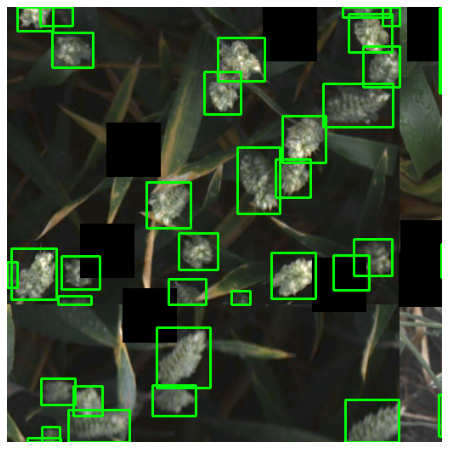

In [60]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

np_image = image.permute(1, 2, 0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box in boxes:
    cv2.rectangle(np_image, (box[1], box[0]), (box[3], box[2]), (0, 1, 0), 2)

ax.set_axis_off()
ax.imshow(np_image)

In [61]:
fold_n = 0

train_dataset = WheatDataset(
    image_ids=df_folds[df_folds['fold'] != fold_n].index.values,
    data=train,
    transforms=get_train_transforms(),
    test=False
)

valid_dataset = WheatDataset(
    image_ids=df_folds[df_folds['fold'] == fold_n].index.values,
    data=train,
    transforms=get_valid_transforms(),
    test=True
)

In [62]:
# computes and stores current and average value

class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [63]:
class Fitter:
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        
        #self.base_dir = f'./{config.folder}'
        self.base_dir = config.folder
        #if not os.path.exists(self.base_dir):
            #os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10 ** 5
        
        self.model = model
        self.device = device
        self.mixed_precision = config.mixed_precision
        self.accumulation = config.accumulation
        
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)

        self.model = model.to(device)
        if self.mixed_precision:
            self.model, self.optimizer = amp.initialize(self.model, self.optimizer, opt_level="O1", verbosity=0)

        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, valid_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')
            
            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)
            
            self.log(f'Train epoch: {self.epoch + 1}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')
            
            t = time.time()
            summary_loss = self.validation(valid_loader)
            
            self.log(f'Valid epoch: {self.epoch + 1}, summary loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if (summary_loss.avg < self.best_summary_loss) and (self.epoch % 10 == 0):
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)
            
            if self.config.valid_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)
                
            self.epoch += 1
    
    def validation(self, valid_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        
        for step, (images, targets, image_ids) in enumerate(valid_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Valid step {step} / {len(valid_loader)}, ' + \
                        f'Summary loss {summary_loss.avg:.5f}, ' + \
                        f'Time {(time.time() - t):.5f}', end='\r'
                    )
            
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]
                
                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)
        
        return summary_loss
    
    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train step {step} / {len(train_loader)}, ' + \
                        f'Summary loss {summary_loss.avg:.5f}, ' + \
                        f'Time {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            
            #self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            if self.mixed_precision:
              with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
            else:
              loss.backward()
            
            if (step + 1) % self.accumulation == 0:
              self.optimizer.step()
              self.optimizer.zero_grad()

            summary_loss.update(loss.detach().item(), batch_size)
            
            #self.optimizer.step()
            
            if self.config.step_scheduler:
                self.scheduler.step()
                
        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch
        }, path)
        
    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict']),
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict']),
        self.scheduler.load_state_dict(checkpoint['sheduler_state_dict']),
        self.best_summary_loss = checkpoint['best_summary_loss'],
        self.epoch = checkpoint['epoch'] + 1
    
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [64]:
class TrainGlobalConfig:
    num_workers = 2
    accumulation = 16
    mixed_precision = True
    batch_size = 2
    n_epochs = 100
    lr = 0.0002
    
    folder = "/content/drive/My Drive/GWD/effdet_stuff"
    
    verbose = True
    verbose_step = 1
    
    step_scheduler = False # scheduler step after optimizer step
    valid_scheduler = True # scheduler step after validation stage loss
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(mode='min', factor=0.5, patience=2, verbose=False,
                           cooldown=0, min_lr=1e-8, eps=1e-08)

In [65]:
def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('/content/drive/My Drive/GWD/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=0.001, momentum=0.01))
    
    return DetBenchTrain(net, config)

net = get_net()

In [66]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn
    )
    
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(valid_dataset),
        pin_memory=False,
        collate_fn=collate_fn
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, valid_loader)

In [67]:
# gaussian noise, scheduler factor

In [ ]:
run()

Fitter prepared. Device is cuda:0

2020-08-02T11:52:01.286302
LR: 0.0002
